### Figure 2
* shared variance vs null
* pcqtl credible sets per tissue 
* counts of both/pcqtl only/eqtl only
* number of egenes colocalized
* distribution of max maringal effect
* distribution of fraction marginal effect
* subsampling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import upsetplot as up
from tqdm.auto import tqdm 
from scipy.stats import spearmanr, linregress, ttest_ind

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import ast
import networkx as nx



tqdm.pandas()

# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_null_clusters import get_null_pcs_annotated


%config InlineBackend.figure_formats = ['png']
# %matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 7})


In [ ]:
qtl_palette = {'pcQTL only':'#620059', 'eQTL only':'#6FA287', 'Both':'#614591', 'Neither':'grey'}

In [3]:
gtex_tissue_dict = {
    "Adipose_Subcutaneous": "#FFA54F",
    "Adipose_Visceral_Omentum": "#EE9A00",
    "Artery_Tibial": "#FF0000",
    "Cells_Cultured_fibroblasts": "#9AC0CD",
    "Esophagus_Mucosa": "#8B7355",
    "Esophagus_Muscularis": "#CDAA7D",
    "Lung": "#9ACD32",
    "Muscle_Skeletal": "#7A67EE",
    "Nerve_Tibial": "#FFD700",
    "Skin_Not_Sun_Exposed_Suprapubic": "#3A5FCD",
    "Skin_Sun_Exposed_Lower_leg": "#1E90FF",
    "Thyroid": "#008B45",
    "Whole_Blood": "#FF00FF"
}

gtex_tissue_abbrev = ['ADPSBQ',
                      'ADPVSC',
                      'ARTTBL',
                      'CELLS',
                      'ESPMCS',
                      'ESPMSL',
                      'LUNG',
                      'MSCLSK',
                      'NERVET',
                      'SKINNS',
                      'SKINS',
                      'THYROID',
                      'WHLBLD']

gtex_tissue_pal = sns.color_palette(list(gtex_tissue_dict.values()))
gtex_tissue_pal_df = pd.DataFrame(pd.Series(gtex_tissue_dict), columns=['hex']).reset_index(names=['tissue_id'])


### shared varaince


In [ ]:
# load in the pcs
pc_annotated = load_across_tissues(config, load_pc_annotated)

# remove clusters with high cross map
clusters_annotated = load_across_tissues(config, load_clusters_annotated)
cross_map_ids = clusters_annotated[clusters_annotated['has_cross_map']]['cluster_id']
# clusters_annotated = remove_cross_map(clusters_annotated, cross_map_ids)
# pc_annotated = remove_cross_map(pc_annotated, cross_map_ids)

# varaince for clusters
cluster_summed_var = []
for n_genes, pc_annotated_group in pc_annotated[(pc_annotated['pc_id']==1)].groupby("cluster_size"):
    cluster_summed_var.append((pc_annotated_group.groupby(["cluster_id", "tissue_id", "pc_id", "cluster_size"])['egene_r2'].agg(sum) - 1)/(n_genes-1))
cluster_summed_var = np.asarray([item for sublist in cluster_summed_var for item in sublist])

In [ ]:
# variance for genome background
# takes ~11m for one tissue
# genome_var = get_null_pcs_annotated(config, 2, 'Cells_Cultured_fibroblasts')
# genome_var.to_csv('/home/klawren/oak/pcqtls/temp/genome_var.csv')

genome_var = pd.read_csv('/home/klawren/oak/pcqtls/temp/genome_var.csv', index_col=0)
genome_summed_var = (genome_var[genome_var['pc_id']==1].groupby(["cluster_id", "pc_id", "cluster_size"])['egene_r2'].agg(sum) - 1)
genome_var.head()

,#chr,start,end,pc_phenotype_id,cluster_id,pc_id,cluster_size,egene_id,egene_r2,egene_slope
0,chr1,923927,959309,ENSG00000187634.11_ENSG00000188976.10_pc1,ENSG00000187634.11_ENSG00000188976.10,1.0,2,ENSG00000187634.11,0.507437,-0.712346
0,chr1,923927,959309,ENSG00000187634.11_ENSG00000188976.10_pc1,ENSG00000187634.11_ENSG00000188976.10,1.0,2,ENSG00000188976.10,0.507428,-0.712340
1,chr1,923927,959309,ENSG00000187634.11_ENSG00000188976.10_pc2,ENSG00000187634.11_ENSG00000188976.10,2.0,2,ENSG00000187634.11,0.492563,0.701828
1,chr1,923927,959309,ENSG00000187634.11_ENSG00000188976.10_pc2,ENSG00000187634.11_ENSG00000188976.10,2.0,2,ENSG00000188976.10,0.492572,-0.701835
2,chr1,959308,960587,ENSG00000187961.13_ENSG00000188976.10_pc1,ENSG00000187961.13_ENSG00000188976.10,1.0,2,ENSG00000187961.13,0.507705,0.712535


In [ ]:
ttest_ind(cluster_summed_var, genome_summed_var).pvalue

0.0

In [ ]:
print(cluster_summed_var.mean()*100)
print(genome_summed_var.mean()*100)

36.61222070593675
7.619354935773276


/local/scratch/klawren/slrmtmp.48257518/ipykernel_17635/459807487.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['correlated', 'uncorrelated'], rotation=0)


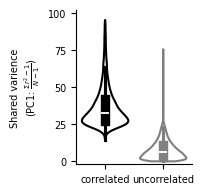

In [ ]:
# violin plot version
fig, ax = plt.subplots(figsize=(1.5, 2))
sns.violinplot({'Clusters':cluster_summed_var, 'Non-cluster pairs':genome_summed_var.values}, ax=ax, palette=['k', 'grey'], fill=False, cut=0)

ax.set_ylim((-.02,1.02))
ax.set_yticks([0, .25,.50, .75, 1])
ax.set_yticklabels([0, 25, 50, 75, 100])
ax.set_ylabel("Shared varience\n(PC1: " r"$\frac{\Sigma r^2-1}{N-1}$)")
ax.spines[['right', 'top']].set_visible(False)

ax.set_xticklabels(['correlated', 'uncorrelated'], rotation=0)
plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_2_shared_varience.pdf", transparent=True)
plt.show()

### pcQTL credible sets across tissues

In [ ]:
susie_annotated = load_across_tissues(config, load_susie_annotated)
clusters = load_across_tissues(config, load_cluster)


In [ ]:
pcqtl_cs_counts = susie_annotated[susie_annotated['type'] == 'pcqtl'].groupby(['tissue_id']).agg({'cs_id':'nunique'})
cluster_counts = clusters.groupby('tissue_id').agg({'Transcripts':'nunique'})
cs_counts = pd.merge(cluster_counts, pcqtl_cs_counts, on='tissue_id')
cs_counts

,Transcripts,cs_id
tissue_id,,
Adipose_Subcutaneous,992,1417
Adipose_Visceral_Omentum,851,920
Artery_Tibial,964,1469
Cells_Cultured_fibroblasts,861,1494
Esophagus_Mucosa,883,1269
Esophagus_Muscularis,787,1029
Lung,947,1058
Muscle_Skeletal,1072,1482
Nerve_Tibial,886,1622


In [ ]:
print(cs_counts['cs_id'].mean())
print(cs_counts['cs_id'].sum())

1396.076923076923
18149


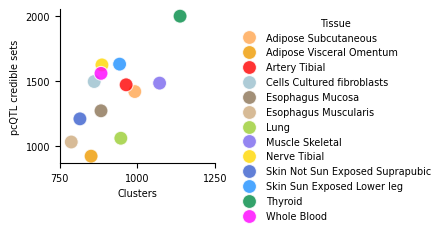

In [ ]:
fig, ax = plt.subplots(figsize=(2,2))

sns.scatterplot(cs_counts, y='cs_id', x='Transcripts', hue='tissue_id', palette=gtex_tissue_pal, ax=ax, s=100, alpha=.8)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.1, 1), frameon=False, title='Tissue')
ax.set_xlabel('Clusters')
ax.set_ylabel('pcQTL credible sets')


legend = ax.get_legend()
new_labels = [label.get_text().replace('_', ' ') for label in legend.texts]
for t, new_label in zip(legend.texts, new_labels):
    t.set_text(new_label)

ax.set_yticks([1000, 1500, 2000])
ax.set_xticks([750, 1000, 1250])

ax.spines[['top', 'right']].set_visible(False)
plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_2_cs_counts.pdf", transparent=True)
plt.show()

### example cluster colocs

In [ ]:
def get_gene_name(gene_id):
    try:
        return gid_gencode.loc[gene_id]['gene_name']
    except KeyError:
        return gene_id
    
gid_gencode, full_gencode = load_gencode()

# get example group
# ENSG00000099974.7_ENSG00000133433.10_ENSG00000240972.1
i = underlying_signals[underlying_signals['num_e_coloc'] > 2].index[24]
# 24
my_cluster_id = underlying_signals.iloc[i]['cluster_id']
my_tissue_id = underlying_signals.iloc[i]['tissue_id']
underlying_signals[(underlying_signals['cluster_id']==my_cluster_id) & (underlying_signals['tissue_id'] == my_tissue_id)]

# pairs for this cluster
cluster_pairs = pair_coloc[(pair_coloc['cluster_id'] == my_cluster_id) & (pair_coloc['tissue_id'] == my_tissue_id)]
cluster_pairs['qtl1_id_short'] = np.where(cluster_pairs['qtl1_id'].str.contains('_e_'), cluster_pairs['qtl1_id'].str.split('_e_').str[-1], 'PC' + cluster_pairs['qtl1_id'].str.split('_pc').str[-1])
cluster_pairs['qtl2_id_short'] = np.where(cluster_pairs['qtl2_id'].str.contains('_e_'), cluster_pairs['qtl2_id'].str.split('_e_').str[-1], 'PC' + cluster_pairs['qtl2_id'].str.split('_pc').str[-1])
cluster_pairs['qtl1_id_short'] = cluster_pairs['qtl1_id_short'].apply(get_gene_name) + '-cs' + cluster_pairs['idx1'].astype(str)
cluster_pairs['qtl2_id_short'] = cluster_pairs['qtl2_id_short'].apply(get_gene_name)+ '-cs' + cluster_pairs['idx2'].astype(str)

# Create an undirected graph
G = nx.Graph()

# Add edges to the graph with weights
for index, row in cluster_pairs.iterrows():
    G.add_edge(row['qtl1_id_short'], row['qtl2_id_short'], weight=row['PP.H4.abf'])

# Get edge weights for thickness
edge_weights = [G[u][v]['weight']*5 for u, v in G.edges()]

edge_colors = ['k' if G[u][v]['weight'] > 0.75 else 'gray' for u, v in G.edges()]
node_colors = [qtl_palette['eQTL only'] if not 'PC' in node else qtl_palette['pcQTL only'] for node in G.nodes()]

fig, ax = plt.subplots(figsize=(5, 4)) 

pos = nx.spring_layout(G, k=1.5)  
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color=node_colors, alpha=0.6, ax=ax)
nx.draw_networkx_edges(G, pos, width=edge_weights, edge_color=edge_colors, alpha=0.5, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax, font_size=8, bbox= dict(facecolor='white', alpha=0.5, edgecolor='k'))
ax.axis('off')  # Turn off the axis

# Create legend
purple_patch = mpatches.Patch(color='k', alpha=0.5, label='colocalized \n(pp4) > 0.75)')
gray_patch = mpatches.Patch(color='gray', alpha=0.5, label='not colocalized \n(pp4) < 0.75)')
ax.legend(handles=[purple_patch, gray_patch], loc='upper right', frameon=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_2_graph.pdf", transparent=True)

plt.show()

### pcQTL credible sets coloc with eQTLs

In [ ]:
underlying_signals = load_across_tissues(config, load_signal_groups)
underlying_signals['cs_id'] = underlying_signals['signal_id'].str.split('-')

KeyboardInterrupt: 

dict_keys(['matrix', 'shading', 'totals', 'intersections'])


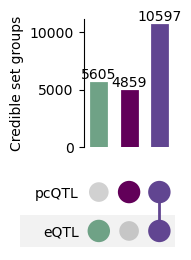

In [ ]:
plt.rcParams.update({'font.size': 10})
underlying_signals['pcQTL'] = underlying_signals['num_pc_coloc'] > 0
underlying_signals['eQTL'] = underlying_signals['num_e_coloc'] > 0
upset = underlying_signals.set_index('eQTL').set_index('pcQTL', append=True)
fig = plt.figure(figsize=(2,3))
upset = up.UpSet(upset, intersection_plot_elements=3, totals_plot_elements = 0, show_counts=True, element_size=None)  # disable the default bar chart
#upset.add_stacked_bars(by="multiple_e_color_label", title="Count", elements=4, colors=('lightgrey', '#67AFD2','#016895'))
upset.style_subsets(present=["eQTL"], absent=["pcQTL"], facecolor=qtl_palette['eQTL only'], linewidth=2)
upset.style_subsets(present=["pcQTL"], absent=["eQTL"], facecolor=qtl_palette['pcQTL only'], linewidth=2)
upset.style_subsets(present=["eQTL", "pcQTL"], facecolor=qtl_palette['Both'], linewidth=2)

# style the instersection plot
plot_result = upset.plot(fig=fig)
print(plot_result.keys())

plot_result['intersections'].set_ylabel("Credible set groups")

plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_2_upset.pdf", transparent=True)
plt.grid(False)
plt.show()
plt.rcParams.update({'font.size': 7})

### number egenes colocalized

In [ ]:
underlying_signals['exclusive_label'] = np.where((underlying_signals['num_e_coloc'] > 0), np.where((underlying_signals['num_pc_coloc'] > 0), 'Both', 'eQTL only'), 'pcQTL only')

underlying_signals.groupby('exclusive_label')['num_e_coloc'].value_counts()

exclusive_label  num_e_coloc
Both             1              7887
                 2              2494
                 3               171
                 4                28
                 5                12
                 6                 3
                 8                 1
                 10                1
eQTL only        1              5545
                 2                59
                 3                 1
pcQTL only       0              4859
Name: count, dtype: int64

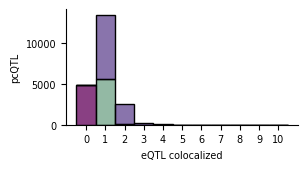

In [ ]:

fig, ax = plt.subplots(figsize=(3, 1.5))

sns.histplot(underlying_signals[underlying_signals['num_e_coloc']>0], x='num_e_coloc', discrete=True, ax=ax, hue='exclusive_label', multiple='stack', legend=False, palette=qtl_palette)
ax.spines[['top', 'right']].set_visible(False)
ax.set_xlabel('eGenes colocalized')
ax.set_ylabel('pcQCredible set gorups')
ax.set_xticks(range(11))
plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_2_num_eqtl_coloc.pdf", transparent=True)

plt.show()

### marginal effects on egenes

In [ ]:
susie_annotated = susie_annotated[~(susie_annotated['egene_id_list'] == '[nan]')]
susie_annotated['egene_qtl_slope'] = susie_annotated['egene_qtl_slope'].progress_apply(ast.literal_eval)
susie_annotated['egene_id_list'] = susie_annotated['egene_id_list'].progress_apply(ast.literal_eval)

  0%|          | 0/892013 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# expand out over all egenes for a given qtl
susie_annotated_egene_explode = susie_annotated.explode(['egene_qtl_slope', 'egene_id_list'])

# weight by pip
susie_annotated_egene_explode['pip_weighted_eqtl_slope'] = susie_annotated_egene_explode['egene_qtl_slope']*susie_annotated_egene_explode['pip']

# group by egene
egene_grouped_eqtl_mapped = susie_annotated_egene_explode.groupby(['phenotype_id', 'cs_id', 'tissue_id', 'egene_id_list']).agg({'type':'first',
                                                                                  'cluster_id':'first',
                                                                                  'lead_variant_id':'first',
                                                                                  'pip_weighted_eqtl_slope':sum,
                                                                                  'pip':sum}).reset_index()
egene_grouped_eqtl_mapped['pip_weighted_eqtl_slope'] = egene_grouped_eqtl_mapped['pip_weighted_eqtl_slope']/egene_grouped_eqtl_mapped['pip']

# group by credible set
cs_grouped_eqtl_mapped = egene_grouped_eqtl_mapped.groupby(['phenotype_id', 'cs_id', 'tissue_id']).agg({'type':'first',
                                                                                  'cluster_id':'first',
                                                                                  'lead_variant_id':'first',
                                                                                  'egene_id_list':list,
                                                                                  'pip_weighted_eqtl_slope':list}).reset_index()

In [ ]:
cs_grouped_eqtl_mapped['max_egene_effect'] = cs_grouped_eqtl_mapped['pip_weighted_eqtl_slope'].apply(lambda x: max([abs(val) for val in x]))
cs_grouped_eqtl_mapped['sum_egene_effect_squared'] = cs_grouped_eqtl_mapped['pip_weighted_eqtl_slope'].apply(lambda x: sum([(val)**2 for val in x]))
cs_grouped_eqtl_mapped['max_egene_effect_squared'] = cs_grouped_eqtl_mapped['max_egene_effect']**2
cs_grouped_eqtl_mapped['frac_largest_egene_effect'] = cs_grouped_eqtl_mapped['max_egene_effect_squared']/cs_grouped_eqtl_mapped['sum_egene_effect_squared']


In [ ]:
# add in the egene effect info
underlying_signals_explode = underlying_signals.explode('cs_id')
underlying_signals_explode = pd.merge(cs_grouped_eqtl_mapped[['cs_id', 'tissue_id', 'max_egene_effect_squared', 'frac_largest_egene_effect']], underlying_signals_explode, on=['cs_id', 'tissue_id'], how='right')

underlying_signals_egene_effect = underlying_signals_explode.groupby(['signal_id', 'tissue_id']).agg({'max_egene_effect_squared':'max', 
                                                                         'num_e_coloc':'first',
                                                                         'num_pc_coloc':'first',
                                                                         'frac_largest_egene_effect':'max'})

underlying_signals_egene_effect = underlying_signals_egene_effect.reset_index()
underlying_signals_egene_effect = underlying_signals_egene_effect[~underlying_signals_egene_effect['max_egene_effect_squared'].isna()]
underlying_signals_egene_effect['exclusive_label'] = np.where((underlying_signals_egene_effect['num_e_coloc'] > 0), np.where((underlying_signals_egene_effect['num_pc_coloc'] > 0), 'Both', 'eQTL only'), 'pcQTL only')

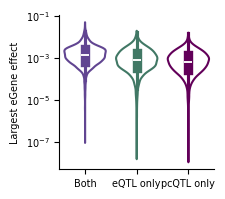

In [ ]:
# qtl max egene effect split by type
fig, ax = plt.subplots(figsize=(2, 2))
sns.violinplot(underlying_signals_egene_effect, x='exclusive_label', y='max_egene_effect_squared',
               common_norm=False, cut=0, log_scale=True, hue='exclusive_label', ax=ax, palette=qtl_palette, fill=False)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('Largest eGene effect')
plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_2_max_effect_type.pdf", transparent=True)

In [ ]:
# pvalues
for label1, label2 in [['Both', 'pcQTL only'], ['Both', 'eQTL only'], ['pcQTL only', 'eQTL only']]:
    print('{}-{}'.format(label1, label2))
    print(ttest_ind(underlying_signals_egene_effect[underlying_signals_egene_effect['exclusive_label']==label1]['max_egene_effect_squared'], underlying_signals_egene_effect[underlying_signals_egene_effect['exclusive_label']==label2]['max_egene_effect_squared']))

Both-pcQTL only
Ttest_indResult(statistic=25.61113505251956, pvalue=1.0916076808381847e-141)
Both-eQTL only
Ttest_indResult(statistic=20.32917129953006, pvalue=9.908671539640191e-91)
pcQTL only-eQTL only
Ttest_indResult(statistic=-8.720146158613765, pvalue=3.2114582710911964e-18)


### fraction effect on egene

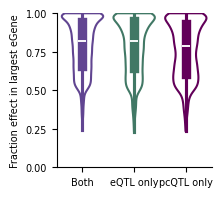

In [ ]:
# qtl frac effect split by type
fig, ax = plt.subplots(figsize=(2, 2))
sns.violinplot(underlying_signals_egene_effect, x='exclusive_label', y='frac_largest_egene_effect', common_norm=False, cut=0, hue='exclusive_label', ax=ax, palette=qtl_palette, fill=False)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('Fraction effect in largest eGene')
ax.set_ylim([0,1])
ax.set_yticks([0, .25, .5, .75, 1])
plt.savefig(f"/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_2_frac_effect_type.pdf", transparent=True)

In [ ]:
# pvalues
for label1, label2 in [['Both', 'pcQTL only'], ['Both', 'eQTL only'], ['pcQTL only', 'eQTL only']]:
    print('{}-{}'.format(label1, label2))
    print(ttest_ind(underlying_signals_egene_effect[underlying_signals_egene_effect['exclusive_label']==label1]['frac_largest_egene_effect'], underlying_signals_egene_effect[underlying_signals_egene_effect['exclusive_label']==label2]['frac_largest_egene_effect']))

Both-pcQTL only
Ttest_indResult(statistic=9.721842135533565, pvalue=2.82289032761843e-22)
Both-eQTL only
Ttest_indResult(statistic=1.8759825540938804, pvalue=0.06067586431673703)
pcQTL only-eQTL only
Ttest_indResult(statistic=-6.70033145802684, pvalue=2.189318399093989e-11)


### subsampling

In [4]:
subsample_output_folder = f'{prefix}/config/subsampling_constant_pcs'

# load in the configs for each 
subsample_nums = [200, 250, 300, 350, 400, 450]

sub_configs = {}
for num_samples in subsample_nums:
    config_path= f'{subsample_output_folder}/{num_samples}_subsample.yaml'
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
        sub_configs[num_samples] = config

main_config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(main_config_path, 'r') as f:
    final_output_config = yaml.safe_load(f)

my_tissue_id = 'Cells_Cultured_fibroblasts'
sample_sizes = pd.read_csv(final_output_config['gtex_meta'], sep='\t')
final_sample_size = sample_sizes[sample_sizes['tissue_id']==my_tissue_id]['sample_size'].values[0]

In [5]:
# takes 13 minutes for 1 tissues and 4 subsamples

# def get_pc_e_nominal(config, tissue_id, thresholds):
#     pc_nominal_df = load_pc_nominal_all_chr(config, tissue_id).groupby(['cluster_id', 'variant_id']).agg({'pval_nominal':min})
#     pc_nominal_df = pd.merge(pc_nominal_df.reset_index(), thresholds.reset_index(), on='cluster_id', how='left')
#     pc_nominal_df['sig'] = pc_nominal_df['pval_nominal'] < pc_nominal_df['pval_nominal_threshold']

#     e_nominal_df = load_e_nominal_all_chr(config, tissue_id).groupby(['cluster_id', 'variant_id']).agg({'pval_nominal':min})
#     e_nominal_df = pd.merge(e_nominal_df.reset_index(), thresholds.reset_index(), on='cluster_id', how='left')
#     e_nominal_df['sig'] = e_nominal_df['pval_nominal'] < e_nominal_df['pval_nominal_threshold']
    
#     combined_nominal = pd.merge(pc_nominal_df, e_nominal_df, suffixes=['_pc', '_e'], on=['cluster_id', 'variant_id']).reset_index()
#     combined_nominal['exclusive_label'] = np.where(combined_nominal['sig_e'],
#                                                np.where(combined_nominal['sig_pc'], 'shared', 'eqtl_only'), 
#                                                np.where(combined_nominal['sig_pc'], 'pcqtl_only', 'neither'))
#     return combined_nominal
# nominal_df = get_pc_e_nominal(final_output_config, my_tissue_id, get_threshold(sub_configs[200], my_tissue_id))
# for key in sub_configs:
#     print(key)
#     sub_nominal_df = final_nominal_df = get_pc_e_nominal(sub_configs[key], my_tissue_id, get_threshold(sub_configs[key], my_tissue_id))
#     nominal_df = pd.merge(nominal_df, sub_nominal_df, suffixes=['', f'_{key}'], on=['cluster_id', 'variant_id'])
# nominal_df.to_csv('/home/klawren/oak/pcqtls/output/subsampling_constant_pcs/merged_bycluster_nominal.txt.gz', sep='\t', compression='gzip', index=False)

# takes about 1 minute to load
nominal_df = pd.read_csv('/home/klawren/oak/pcqtls/output/subsampling_constant_pcs/merged_bycluster_nominal.txt.gz', sep='\t', compression='gzip')

In [10]:
nominal_df.head()

,index,cluster_id,variant_id,pval_nominal_pc,pval_nominal_threshold_pc,sig_pc,pval_nominal_e,pval_nominal_threshold_e,sig_e,exclusive_label,...,sig_e_400,exclusive_label_400,index_450,pval_nominal_pc_450,pval_nominal_threshold_pc_450,sig_pc_450,pval_nominal_e_450,pval_nominal_threshold_e_450,sig_e_450,exclusive_label_450
0,0,ENSG00000000971.15_ENSG00000162687.16,chr1_195609378_G_A_b38,0.143330,0.000531,False,0.329346,0.000531,False,neither,...,False,neither,0,0.076285,0.001481,False,0.132071,0.001481,False,neither
1,1,ENSG00000000971.15_ENSG00000162687.16,chr1_195609648_G_A_b38,0.348916,0.000531,False,0.255249,0.000531,False,neither,...,False,neither,1,0.181053,0.001481,False,0.210406,0.001481,False,neither
2,2,ENSG00000000971.15_ENSG00000162687.16,chr1_195610883_A_G_b38,0.154563,0.000531,False,0.053508,0.000531,False,neither,...,False,neither,2,0.194838,0.001481,False,0.083235,0.001481,False,neither
3,3,ENSG00000000971.15_ENSG00000162687.16,chr1_195611518_T_C_b38,0.188656,0.000531,False,0.174350,0.000531,False,neither,...,False,neither,3,0.268750,0.001481,False,0.286052,0.001481,False,neither
4,4,ENSG00000000971.15_ENSG00000162687.16,chr1_195611885_T_C_b38,0.507114,0.000531,False,0.662446,0.000531,False,neither,...,False,neither,4,0.707001,0.001481,False,0.668500,0.001481,False,neither


In [39]:
num_cutoffs = 10
num_subsamples = len(range(200, 451, 50))
subsample_colors_pc = sns.color_palette("light:#620059", num_subsamples + 2)[2:] 
subsample_colors_e = sns.color_palette("light:#6FA287", num_subsamples + 2)[2:] 

data = []

for i in range(num_cutoffs)[::-1]:
    nominal_cutoff = 10**(-i/2)
    sub_pc_vars = nominal_df[nominal_df['pval_nominal_pc_200'] < nominal_cutoff]
    #sub_e_vars = nominal_df[nominal_df['pval_nominal_pc_200'] < nominal_cutoff]
    mean_pc_values = sub_pc_vars[[f'sig_pc_{col}' for col in range(200, 451, 50)]].mean(axis=0)
    mean_e_values = sub_pc_vars[[f'sig_e_{col}' for col in range(200, 451, 50)]].mean(axis=0)
    
    for j, sample_size in enumerate(range(200, 451, 50)):
        data.append({'Nominal Cutoff': nominal_cutoff, 'Sample Size': sample_size, 'Mean PC Values': mean_pc_values[j], 'Mean E Values': mean_e_values[j]})

data_df = pd.DataFrame(data)

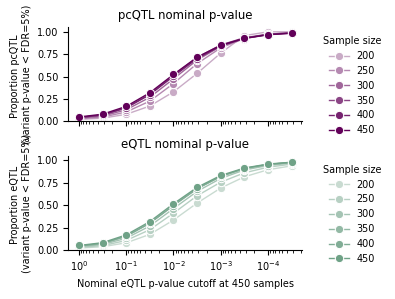

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 3), sharex=True)

sns.lineplot(data=data_df, x='Nominal Cutoff', y='Mean PC Values', hue='Sample Size', palette=subsample_colors_pc, lw=1, marker='o', ax=ax1)
ax1.set_xscale('log')
ax1.invert_xaxis()
ax1.spines[['top', 'right']].set_visible(False)
ax1.set_ylim([0, 1.05])
ax1.set_yticks([0, .25, .5, .75, 1])
ax1.set_ylabel('Proportion pcQTL \n(variant p-value < FDR=5%)')
ax1.set_title('pcQTL nominal p-value')


# Plotting for Mean E Values
sns.lineplot(data=data_df, x='Nominal Cutoff', y='Mean E Values', hue='Sample Size', palette=subsample_colors_e, lw=1, marker='o', ax=ax2)
ax2.spines[['top', 'right']].set_visible(False)
ax2.set_ylim([0, 1.05])
ax2.set_yticks([0, .25, .5, .75, 1])
ax2.set_xlabel('Nominal eQTL p-value cutoff at 450 samples')
ax2.set_ylabel('Proportion eQTL \n(variant p-value < FDR=5%)')
ax2.set_title('eQTL nominal p-value')


# Move the legend outside of the plots
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, title='Sample size', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, title='Sample size', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)


plt.tight_layout()
plt.savefig("/home/klawren/oak/pcqtls/workflow/notebooks/figures/figure_2_subsample.pdf", transparent=True)
plt.show()